# Exploratory data analysis

We started our journey with a hypothesis: "_there should be some connection between amenities and traffic!_". Indeed, as a citizen, you wake up, drink a cup of coffee, go to work. During the day you eat lunch, do shopping, gym etcetera. So, there is a reason for you to leave home, right? And to get to so called a place of interest (POI) you use a certain mode of transport. Let us imagine that there is a single way to travel in the city: metro. With this notebook, we are going to explore what are the __relationships between amenities__ and the __underground traffic__.

One of the critical aspect of this study is the choice of "the right" resolution or the area to analyze. The options are: 
* operate with official statistical boundaries (boroughs and wards);
* crete a custom hexgrid;
* use Voronoi tesselation.

The are pros and cons of using each of these options. By using official statistical boundaries we are ensuring that the numbers are "correct". For examplee, population of a borough is 5000 citizens. However, ... 

We will start our analysis by exploring whether or not amenities and population are "correlated." Secondly, we will cluster amenities into groups and compare these groups with the clusters of Verma et al. (2020). In this work, authors 

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
import numpy as np

from scipy import spatial
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from shapely.geometry import Point, Polygon, box, shape

# Load user-defined functions
from src.create_hexgrid import create_hexgrid
from src.vizualization import scatterplot, choropleth # , plot_hexgrid

plt.style.use('seaborn-whitegrid')

## 1. Amenities and population

### Municipal boundaries

In [2]:
# Select the resolution
resolution = 'wards'
if resolution == 'wards':
    column_id = 'WD11CD_BF'
elif resolution == 'boroughs':
    column_id = 'LAD11NM'
else:
    raise ValueError("You haven't specified the resoultion or specified it wrongly.")
print(f'Chosen resolution : {resolution.capitalize()}')

Chosen resolution : Wards


In [3]:
# Load the data
population = gpd.read_file(f'../data/processed/population/{resolution}.json')
population = population[[f'{column_id}', 'total_population', 'adult_population', 'geometry']] # keep only the columns of interest
population.set_index(f'{column_id}', inplace=True) # change index to make merge easier
pois_counts = pd.read_csv(f'../data/processed/pois/pois_counts_{resolution}.csv')

# Change index to make merge easier
pois_counts.set_index('pois_category', inplace=True)

# Let's combine population and pois counts
df = pd.concat([pois_counts, population.T])
df.fillna(0, inplace=True)

# Prepare a GeoDataFrame
gdf = gpd.GeoDataFrame(df.T, geometry='geometry')
gdf.crs = population.crs
gdf.to_crs(epsg=3857, inplace=True)

# Make sure that all values are numeric
gdf.loc[:,:'adult_population'] = gdf.loc[:,:'adult_population'].apply(pd.to_numeric)

Can we find a pattern between the number of amenties by type and population?

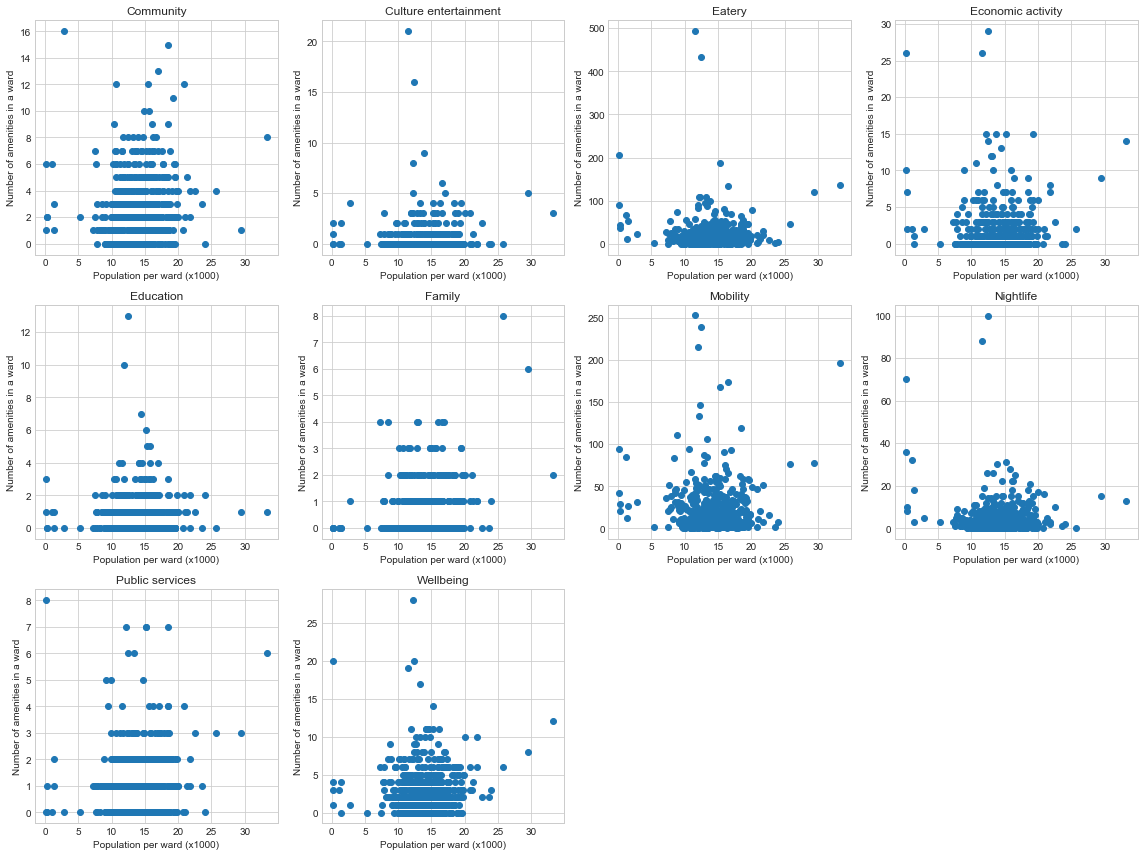

In [4]:
scatterplot(df, savefig=True)

What about the map? Can we find some explainable patterns if visualize the distribution of amenities geographically?

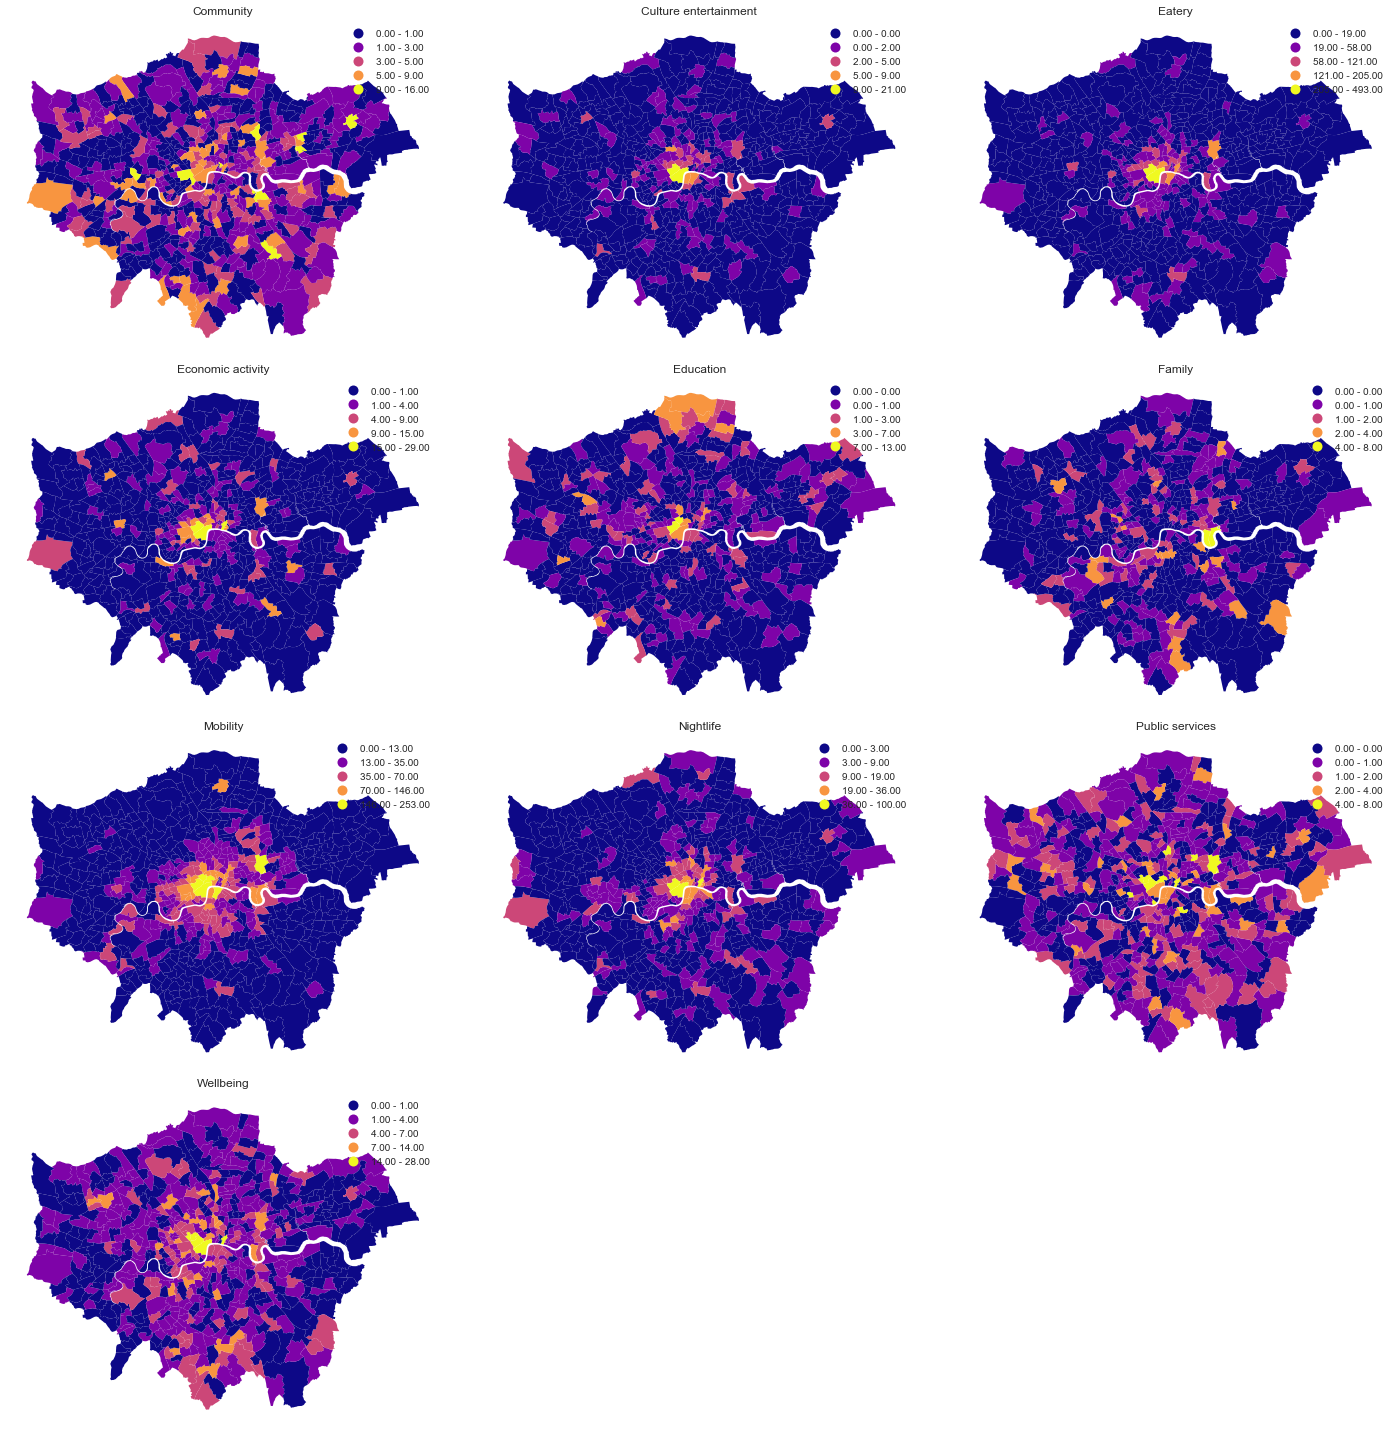

In [5]:
choropleth(gdf, cmap='plasma', savefig=True)

### Hexgrid

In [39]:
# Load POIs data
pois = pd.read_csv('../data/processed/pois/pois.csv', low_memory=False)
pois = gpd.GeoDataFrame(pois, geometry=gpd.points_from_xy(pois['lon'], pois['lat']))
pois.crs = {'init':'epsg:4326'}
pois_categories = pd.read_csv("../data/external/pois_categories.csv")

In [40]:
# Merge pois with categories
pois = pd.merge(pois, pois_categories, left_on='amenity', right_on='pois')
pois.drop('amenity', axis=1, inplace=True)

# Remove amenities tagged 'misc'
pois = pois[pois['pois_category'] != 'misc']

In [41]:
# Polygons here = borougs/wards
polygons = gdf[['geometry']].reset_index(drop=True)
polygons = polygons.to_crs(4326)

# Create a hexgrid
hex_res = 7
resolution = f'hex_id_{hex_res}'
buffer = 0.005
plot = False
hexgrid = create_hexgrid(polygons, hex_res=hex_res, buffer=buffer, plot=plot)
hexgrid.reset_index(drop=True, inplace=True)
hexgrid.crs = {'init': 'epsg:4326', 'no_defs': True}
# hexgrid.to_crs(3395).plot()
# plt.axis('off');

In [42]:
# Distribute population over the hexgrids equally (based on the area)
gdf.to_crs(epsg=4326, inplace=True)
gdf = gdf.reset_index(drop=True)

hexgrid['total_population'] = 0

hexgrid_polygons = [shape(polygon) for polygon in hexgrid["geometry"].tolist()]
polygons = [shape(polygon) for polygon in gdf["geometry"].tolist()]

for i, hexgrid_polygon in tqdm(enumerate(hexgrid_polygons), total=len(hexgrid_polygons)):
    for j, polygon in enumerate(polygons):
        if hexgrid_polygon.intersects(polygon):
            intersect = (hexgrid_polygon.intersection(polygon).area / hexgrid_polygon.area)
            hexgrid.loc[i, "total_population"] += (gdf.loc[j, "total_population"] * intersect)

100%|███████████████████████████████████████████████████████████████████████████████| 365/365 [00:02<00:00, 152.87it/s]


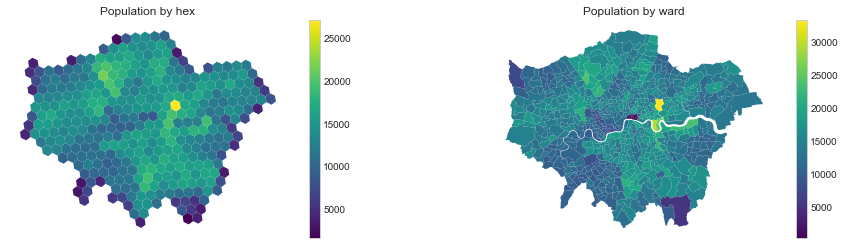

In [43]:
# Compare result visually 
fig, ax = plt.subplots(ncols=2, figsize=(16,4))
hexgrid.to_crs(epsg=3395).plot(column='total_population', cmap='viridis', legend=True, ax=ax[0]) # scheme='fisher_jenks', 
gdf.to_crs(epsg=3395).plot(column='total_population', cmap='viridis', legend=True, ax=ax[1]) # , scheme='fisher_jenks', )
ax[0].axis('off')
ax[0].set_title(f'Population by hex')
ax[1].set_title(f'Population by ward')
ax[1].axis('off');

In [44]:
# Pois in hex?
pois_in_hex = gpd.sjoin(pois, hexgrid)
# pois_in_hex

# Create an empty column for counting
pois_in_hex['n'] = 1

# Pois in hex by category
pois_in_hex_by_cat = pois_in_hex.groupby(['pois_category', resolution]).sum()

C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!({'init': 'epsg:4326'} != {'init': 'epsg:4326', 'no_defs': True})
  "(%s != %s)" % (left_df.crs, right_df.crs)
C:\Users\Mikhail\AppData\Local\Continuum\miniconda3\envs\heatvuln\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [45]:
hexgrid_population = hexgrid.set_index(resolution)['total_population']
# hexgrid.drop('total_population', axis=1, inplace=True)

In [46]:
x = np.arange(10)
ys = [i + x + (i * x)**2 for i in range(10)]
colors = cm.tab10(np.linspace(0, 1, len(ys)))

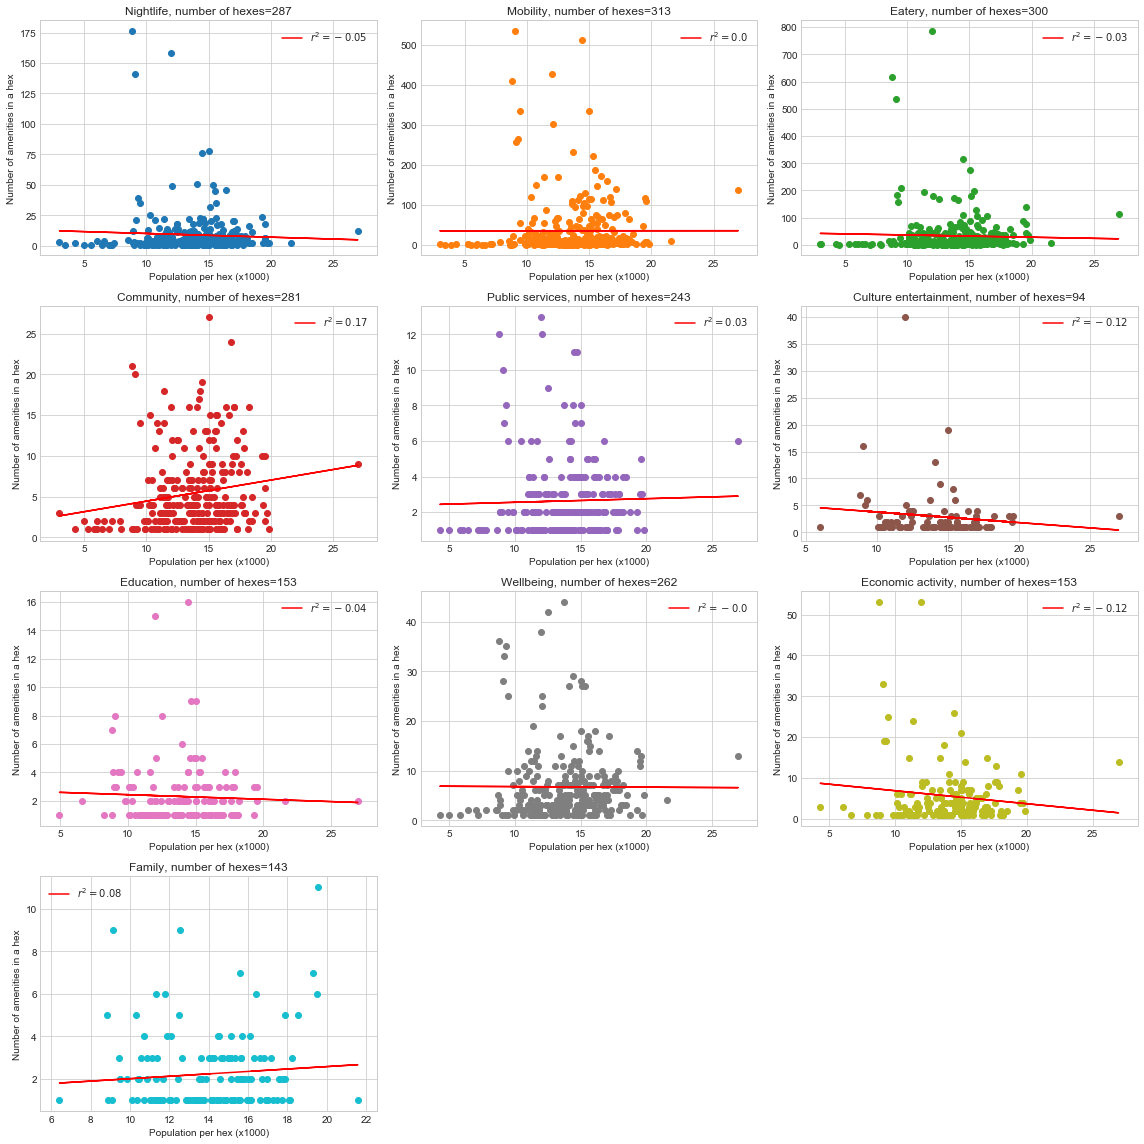

In [51]:
nrows = 4
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
k = 0
columns = pois['pois_category'].unique().tolist()
for i in range(nrows):
    for j in range(ncols):
        merged = pd.merge(pois_in_hex_by_cat.loc[columns[k]], hexgrid, left_on=pois_in_hex_by_cat.loc[columns[k]].index, right_on=resolution)
        X = merged['total_population_y'].div(1000).values
        y = merged['n']
        slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)
        line = slope * X + intercept
        ax[i, j].plot(X, line, label= f'$r^2={round(r_value, 2)}$', color='red')
        ax[i, j].scatter(X, y, color=colors[k])
        ax[i, j].set_title(f'{columns[k].capitalize().replace("_", " ")}, number of hexes={merged.shape[0]}')
        ax[i, j].set_ylabel('Number of amenities in a hex')
        ax[i, j].set_xlabel('Population per hex (x1000)')
        ax[i, j].legend()
        k += 1
        if k == 10:
            break
        
fig.delaxes(ax[3, 1])
fig.delaxes(ax[3, 2])
fig.tight_layout()
plt.savefig('../figures/scatter-hex.png', dpi=300)

In [ ]:
nrows = 4
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20), sharex=True)
k = 0
columns = pois['pois_category'].unique().tolist()
for i in range(nrows):
    for j in range(ncols):
        merged = pd.merge(pois_in_hex_by_cat.loc[columns[k]], hexgrid, left_on=pois_in_hex_by_cat.loc[columns[k]].index, right_on=resolution)
        merged = gpd.GeoDataFrame(merged, geometry='geometry')
        merged.crs = {'init':'epsg:4326'}
        hexgrid.to_crs(epsg=3857).plot(color='gray', alpha=.5, ax=ax[i,j], linewidth=0.1, edgecolor='black')
        merged.to_crs(epsg=3857).plot(column='n', ax=ax[i, j], legend=True, scheme='fisher_jenks', cmap='plasma')
        ax[i, j].set_title(f'{columns[k].capitalize().replace("_", " ")}')
        ax[i, j].axis('off')
        k += 1
        if k == 10:
            break
        
fig.delaxes(ax[3, 1])
fig.delaxes(ax[3, 2])
fig.tight_layout()
plt.savefig('../figures/choropleth-hex.png', dpi=300)

## 2. Amenities and traffic

In [ ]:
pois_counts = pois_in_hex.groupby(['pois_category', f'hex_id_{hex_res}']).agg(len)
pois_counts = pois_counts.reset_index()
pois_counts = pois_counts.pivot(index="pois_category", columns=f'hex_id_{hex_res}', values= "name")
pois_counts = pois_counts.fillna(0)
pois_counts = pois_counts.T

In [ ]:
columns = pois_counts.loc[:,:'wellbeing'].columns.tolist()

In [ ]:
sns.heatmap(pois_counts.corr(), annot=True);

In [ ]:
# Assign population
merged = pd.merge(pois_counts, hexgrid_population, left_index=True, right_index=True)

In [ ]:
merged[columns] = merged[columns].div(merged['total_population'], axis=0).multiply(1000)

In [ ]:
X_scaled = StandardScaler().fit_transform(merged.loc[:,:'wellbeing'])

In [ ]:
k_min = 2
k_max = 20

models = {}
labels = {}

init = 'k-means++'
n_init = 100
random_state = 1235

print(f'Perform K-means clustering with {n_init} {init} centorid initalizations.')

In [ ]:
for k in tqdm(range(k_min, k_max + 1)):
    kmeans = KMeans(n_clusters=k, init='k-means++', n_init=n_init, random_state=random_state)
    models[k] = kmeans.fit(X_scaled)
    labels[k] = models[k].labels_

In [ ]:
# Silhouette, Calinski-Harabasz, Davies-Bouldin
clustering_metrics = {}
ss = {}
ch = {}
db = {}

delimiter = 1

for key, value in models.items():
    ss[key] = silhouette_score(X_scaled, labels[key], random_state=random_state)
    ch[key] = round(calinski_harabasz_score(X_scaled, labels[key]) / delimiter, 3)
    db[key] = round(davies_bouldin_score(X_scaled, labels[key]), 3)
    
clustering_metrics["Silhouette score"] = ss
clustering_metrics["Calinski-Harabasz"] = ch
clustering_metrics["Davies-Bouldin"] = db

In [ ]:
ax = pd.DataFrame(clustering_metrics).plot(subplots=True, layout=(1, 3), figsize=(12, 4), rot=0, xticks=np.arange(k_min, k_max + 1), sharex=False);
for i in range(0, 3):
    ax[0, i].set_xlabel('Number of components')
    ax[0, i].set_ylabel('Metric score')
plt.tight_layout()

In [ ]:
n_clusters = 4
np.unique(labels[n_clusters], return_counts=True)

In [ ]:
merged['label'] = labels[n_clusters]

In [ ]:
merged[columns + ['label']].groupby('label').sum().plot.bar(figsize=(20,6), rot=90);

In [ ]:
merged = pd.merge(hexgrid, merged, left_on=f'hex_id_{hex_res}', right_index=True)

In [ ]:
merged.to_crs(epsg=3857).plot(column='label', categorical=True, legend=True, figsize=(10,8))
plt.axis('off');

In [ ]:
# Connect station traffic and the number of amenities of a specific type
stations = gpd.read_file('../data/external/entry_station_cluster.json')
sjoin = gpd.sjoin(merged, stations, how="inner", op="contains")

In [ ]:
nrows = 4
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16), sharex=True)
k = 0
columns = pois['pois_category'].unique().tolist()
for i in range(nrows):
    for j in range(ncols):
        X = sjoin['total']
        y = sjoin[columns[k]]
        ax[i, j].scatter(X, y, color=colors[k])
        ax[i, j].set_title(f'{columns[k].capitalize().replace("_", " ")}')
        ax[i, j].set_xlabel('Entry')
        ax[i, j].set_ylabel('Amenities (x1000 citizens)')
        k += 1
        if k == 10:
            break
        
fig.delaxes(ax[3, 1])
fig.delaxes(ax[3, 2])
fig.tight_layout()